# Neural network for classification - Full batch optimization

We construct a neural network for classification using [PyTorch](https://pytorch.org/). The implementation is written to accept an arbitrary number of layers and also an arbitrary number of neurons in each layer.

First, we load some important packages which will be used throughout this notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft, fftfreq
from scipy.signal import argrelextrema
import time
import peakutils
import pickle
import pandas as pd

from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

Since our main point is to estimate quantities as entropy and mutual information (MI), with which we intended to analyze training dynamics, we define a function to store information collected during the optimization procedure.

In [11]:
def save_obj(obj, name):
    with open('../training_files/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

## Loading input data

At least in the this beginning, we will consider two possible datasets:

- The one used by Shwartz-Ziv and Tishby in their work [Opening the Black Box of Deep Neural Networks via Information](https://arxiv.org/abs/1703.00810), collected [here](https://github.com/ravidziv/IDNNs/tree/master/data) in the `var_u.mat` file.


- A dataset of Ising two dimensional configurations, obtained by us with Monte Carlo sampling of the Boltzmann distribution, considering only nearest neighbors exchange interaction.

Since we want to validate previous results from Tishby's group, we begin by considering only their dataset.


## Loading  Shwartz-Ziv/Tishby data

To load the data, we make use of the the functions defined in the file `utils.py`, written by Saxe and coworkers. This code is part of their work [On the Information Bottleneck Theory of Deep Learning](https://openreview.net/pdf?id=ry_WPG-A-).


In [4]:
import sys
sys.path.insert(0, '../estimators')
import utils

train, test = utils.get_IB_data('2017_12_21_16_51_3_275766')

Once the dataset is load, we express it in the language of PyTorch tensors.

In [5]:
X_train = torch.tensor(train.X, dtype= torch.float)
y_train = torch.tensor(train.Y, dtype= torch.float)

X_test = torch.tensor(test.X, dtype= torch.float)
y_test = torch.tensor(test.Y, dtype= torch.float)

## Loading Ising data

In [3]:
data = pd.read_pickle('../data/l04_full_state_phase.pkl')

In [4]:
data.head()

,state,temp,ordered,desordered
0,"[1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1]",6.0,0,1
1,"[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0]",6.0,0,1
2,"[1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1]",6.0,0,1
3,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1]",6.0,0,1
4,"[0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]",6.0,0,1


In [5]:
data.shape

(600000, 4)

Once the dataset is load, we express it in the language of PyTorch tensors.

In [ ]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size= 0.2, random_state= 12)

In [ ]:
X_train = torch.tensor(list(train_data['state']), dtype= torch.float)
y_train = torch.tensor(np.array(train_data[['ordered', 'desordered']]) ,dtype= torch.float)

X_test = torch.tensor(list(test_data['state']), dtype= torch.float)
y_test = torch.tensor(np.array(test_data[['ordered', 'desordered']]))

## Constructing the network: `Net` class

In [6]:
class Net(nn.Module):
    '''
    NEURAL NETWORK WITH L LAYERS
    - layers_size: list of the number of neurons from the input layer to the (L-1)-th layer [n_imput, N_1, ..., N_{L_1}]
    - out_size: size of the output layer
    '''
    def __init__(self, layers_size, out_size):
        super(Net, self).__init__()
        
        self.layers = nn.ModuleList()
        
        ### HIDDEN LINEAR LAYERS (the activation is applied in the forward method)        
        for k in range(len(layers_size) - 1):
            self.layers.append(nn.Linear(layers_size[k], layers_size[k+1]))
            
        ### OUTPUT LINEAR LAYERS (the activation is applied in the forward method) 
        self.out = nn.Linear(layers_size[-1], out_size)
        
        ### WEIGHT INITIALIZATION
        # Weight matrices: Gaussian initialization
        # Bias vectors: constant initizalization
        #for m in self.layers:
        #    nn.init.normal_(m.weight, mean= 0, std= 0.001)
        #    nn.init.constant_(m.bias, 0.0001)
        
        #nn.init.normal_(self.out.weight, mean= 0, std= 0.001)
        #nn.init.constant_(self.out.bias, 0.0001)
        
        
    def forward(self, x):
        
        j = 1
        
        ### Dictionary to store all the activation values for each epoch
        # Necessary to the MI estimation
        act_state = {
            'activity' : []
        }
        
        for layer in self.layers:
            
            
            ### TANH neural network            
            x = F.tanh(layer(x))
                      
            # Storing the activations  
            act_state['activity'].append( x.detach().numpy())
            j = j + 1
        
        ### SOFTMAX output
        output= F.softmax(self.out(x), dim=1)
        
        act_state['activity'].append( output.detach().numpy())
            
        return output, act_state

## Training

In [7]:
### DEFINING NETWORK ARCHITETURE

input_size = X_train.shape[1]
out_size = y_train.shape[1]
layers_size = [input_size, 10, 7, 5, 4, 3]

net = Net(layers_size, out_size)     
print(net)

### DEFINING OPTIMIZER AND LOSS FUNCTION

optimizer = optim.SGD(net.parameters(), lr= 0.01)
loss_func = nn.BCELoss()

### INITIALIZING TRAINING AND STORING IMPORTANT INFORMATION

log_dic = {
    'epoch': [],
    'loss' : [],
    'data' : [],
    'loss_gen': []
}

weights = {'weights_norm' : [],
           'grad_mean'    : [],
           'grad_std'     : []
           }  # Recording weights norm


for epoch in range(8000):
       
    t0 = time.time()
    
    prediction, act_state = net(X_train)     # input x and predict based on x
                                             # act_state provides the activation values for each neuron
                                             # in each layer
      
    loss = loss_func(prediction, y_train)     # must be (1. nn output, 2. target)
    
    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    
    ##################################################################################
    
    for n in range(0, 2*len(layers_size), 2):
        
        W = list(net.parameters())[n]
        
        weights['weights_norm'].append( np.linalg.norm(W.detach().numpy(), ord=2) )
        weights['grad_mean'].append( np.absolute(W.grad.mean().item()) )
        weights['grad_std'].append( W.grad.std().item())        
    
    ############## RECORDING
    log_dic['epoch'].append(epoch)
    log_dic['loss'].append(loss.item())
    log_dic['data'].append({**act_state, **weights})
    
    test_pred, _ = net(X_test)
    log_dic['loss_gen'].append(loss_func(test_pred, y_test ).item())
    
    ##################################################################################
        
    optimizer.step()        # apply gradients
    
     ############ TIME COMPUTING ALL THE INFORMATION ########
    t1 = time.time()
    ########################################################
    
    ########### TRAINING STATUS ########
    print('Epoch %d, Loss= %.10f, Time= %.4f' % (epoch, loss, t1-t0))
    

Net(
  (layers): ModuleList(
    (0): Linear(in_features=12, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=7, bias=True)
    (2): Linear(in_features=7, out_features=5, bias=True)
    (3): Linear(in_features=5, out_features=4, bias=True)
    (4): Linear(in_features=4, out_features=3, bias=True)
  )
  (out): Linear(in_features=3, out_features=2, bias=True)
)
Epoch 0, Loss= 0.7037363052, Time= 0.6132
Epoch 1, Loss= 0.7035911083, Time= 0.0131
Epoch 2, Loss= 0.7034511566, Time= 0.0075
Epoch 3, Loss= 0.7033150792, Time= 0.0080
Epoch 4, Loss= 0.7031776905, Time= 0.0069
Epoch 5, Loss= 0.7030425072, Time= 0.0086
Epoch 6, Loss= 0.7029098272, Time= 0.0086
Epoch 7, Loss= 0.7027771473, Time= 0.0083
Epoch 8, Loss= 0.7026482821, Time= 0.0084
Epoch 9, Loss= 0.7025210857, Time= 0.0119
Epoch 10, Loss= 0.7023949027, Time= 0.0132
Epoch 11, Loss= 0.7022696733, Time= 0.0170
Epoch 12, Loss= 0.7021496296, Time= 0.0109
Epoch 13, Loss= 0.7020279765, Time= 0.0108
Epoch 14, Loss= 0.7019

Epoch 180, Loss= 0.6943106055, Time= 0.0162
Epoch 181, Loss= 0.6943012476, Time= 0.0120
Epoch 182, Loss= 0.6942882538, Time= 0.0144
Epoch 183, Loss= 0.6942777038, Time= 0.0123
Epoch 184, Loss= 0.6942653656, Time= 0.0103
Epoch 185, Loss= 0.6942524910, Time= 0.0119
Epoch 186, Loss= 0.6942427158, Time= 0.0098
Epoch 187, Loss= 0.6942322254, Time= 0.0100
Epoch 188, Loss= 0.6942214966, Time= 0.0094
Epoch 189, Loss= 0.6942089796, Time= 0.0096
Epoch 190, Loss= 0.6941978335, Time= 0.0090
Epoch 191, Loss= 0.6941868663, Time= 0.0146
Epoch 192, Loss= 0.6941751838, Time= 0.0110
Epoch 193, Loss= 0.6941657066, Time= 0.0108
Epoch 194, Loss= 0.6941558719, Time= 0.0106
Epoch 195, Loss= 0.6941446066, Time= 0.0113
Epoch 196, Loss= 0.6941363215, Time= 0.0129
Epoch 197, Loss= 0.6941275001, Time= 0.0081
Epoch 198, Loss= 0.6941165924, Time= 0.0145
Epoch 199, Loss= 0.6941064000, Time= 0.0104
Epoch 200, Loss= 0.6940947175, Time= 0.0115
Epoch 201, Loss= 0.6940858960, Time= 0.0113
Epoch 202, Loss= 0.6940771937, T

Epoch 383, Loss= 0.6932679415, Time= 0.0144
Epoch 384, Loss= 0.6932651401, Time= 0.0099
Epoch 385, Loss= 0.6932622194, Time= 0.0102
Epoch 386, Loss= 0.6932613254, Time= 0.0081
Epoch 387, Loss= 0.6932585835, Time= 0.0090
Epoch 388, Loss= 0.6932557225, Time= 0.0102
Epoch 389, Loss= 0.6932538748, Time= 0.0143
Epoch 390, Loss= 0.6932507753, Time= 0.0095
Epoch 391, Loss= 0.6932497025, Time= 0.0082
Epoch 392, Loss= 0.6932463646, Time= 0.0124
Epoch 393, Loss= 0.6932446957, Time= 0.0104
Epoch 394, Loss= 0.6932413578, Time= 0.0092
Epoch 395, Loss= 0.6932398677, Time= 0.0124
Epoch 396, Loss= 0.6932374239, Time= 0.0123
Epoch 397, Loss= 0.6932322979, Time= 0.0100
Epoch 398, Loss= 0.6932314038, Time= 0.0121
Epoch 399, Loss= 0.6932291985, Time= 0.0109
Epoch 400, Loss= 0.6932284832, Time= 0.0084
Epoch 401, Loss= 0.6932282448, Time= 0.0111
Epoch 402, Loss= 0.6932216883, Time= 0.0115
Epoch 403, Loss= 0.6932209730, Time= 0.0098
Epoch 404, Loss= 0.6932181716, Time= 0.0130
Epoch 405, Loss= 0.6932165027, T

Epoch 577, Loss= 0.6928635240, Time= 0.0162
Epoch 578, Loss= 0.6928610206, Time= 0.0175
Epoch 579, Loss= 0.6928582788, Time= 0.0153
Epoch 580, Loss= 0.6928562522, Time= 0.0091
Epoch 581, Loss= 0.6928538680, Time= 0.0081
Epoch 582, Loss= 0.6928531528, Time= 0.0131
Epoch 583, Loss= 0.6928525567, Time= 0.0111
Epoch 584, Loss= 0.6928493381, Time= 0.0088
Epoch 585, Loss= 0.6928469539, Time= 0.0114
Epoch 586, Loss= 0.6928473115, Time= 0.0165
Epoch 587, Loss= 0.6928448081, Time= 0.0105
Epoch 588, Loss= 0.6928433180, Time= 0.0093
Epoch 589, Loss= 0.6928420663, Time= 0.0119
Epoch 590, Loss= 0.6928398609, Time= 0.0090
Epoch 591, Loss= 0.6928386688, Time= 0.0107
Epoch 592, Loss= 0.6928361058, Time= 0.0090
Epoch 593, Loss= 0.6928337216, Time= 0.0083
Epoch 594, Loss= 0.6928319335, Time= 0.0082
Epoch 595, Loss= 0.6928300261, Time= 0.0078
Epoch 596, Loss= 0.6928280592, Time= 0.0098
Epoch 597, Loss= 0.6928262711, Time= 0.0114
Epoch 598, Loss= 0.6928228140, Time= 0.0144
Epoch 599, Loss= 0.6928198338, T

Epoch 778, Loss= 0.6924723387, Time= 0.0078
Epoch 779, Loss= 0.6924713254, Time= 0.0085
Epoch 780, Loss= 0.6924684644, Time= 0.0084
Epoch 781, Loss= 0.6924661994, Time= 0.0098
Epoch 782, Loss= 0.6924641728, Time= 0.0092
Epoch 783, Loss= 0.6924624443, Time= 0.0106
Epoch 784, Loss= 0.6924606562, Time= 0.0109
Epoch 785, Loss= 0.6924594641, Time= 0.0140
Epoch 786, Loss= 0.6924579740, Time= 0.0136
Epoch 787, Loss= 0.6924560666, Time= 0.0100
Epoch 788, Loss= 0.6924539804, Time= 0.0081
Epoch 789, Loss= 0.6924517751, Time= 0.0121
Epoch 790, Loss= 0.6924492717, Time= 0.0121
Epoch 791, Loss= 0.6924465299, Time= 0.0131
Epoch 792, Loss= 0.6924450994, Time= 0.0154
Epoch 793, Loss= 0.6924427748, Time= 0.0081
Epoch 794, Loss= 0.6924411654, Time= 0.0088
Epoch 795, Loss= 0.6924396753, Time= 0.0089
Epoch 796, Loss= 0.6924389005, Time= 0.0101
Epoch 797, Loss= 0.6924372911, Time= 0.0089
Epoch 798, Loss= 0.6924355626, Time= 0.0119
Epoch 799, Loss= 0.6924338937, Time= 0.0182
Epoch 800, Loss= 0.6924327016, T

Epoch 980, Loss= 0.6920554638, Time= 0.0123
Epoch 981, Loss= 0.6920531988, Time= 0.0153
Epoch 982, Loss= 0.6920503974, Time= 0.0119
Epoch 983, Loss= 0.6920485497, Time= 0.0124
Epoch 984, Loss= 0.6920464635, Time= 0.0086
Epoch 985, Loss= 0.6920444965, Time= 0.0121
Epoch 986, Loss= 0.6920406222, Time= 0.0093
Epoch 987, Loss= 0.6920384765, Time= 0.0072
Epoch 988, Loss= 0.6920358539, Time= 0.0103
Epoch 989, Loss= 0.6920335293, Time= 0.0081
Epoch 990, Loss= 0.6920308471, Time= 0.0109
Epoch 991, Loss= 0.6920288801, Time= 0.0082
Epoch 992, Loss= 0.6920265555, Time= 0.0108
Epoch 993, Loss= 0.6920250654, Time= 0.0077
Epoch 994, Loss= 0.6920226216, Time= 0.0099
Epoch 995, Loss= 0.6920205355, Time= 0.0087
Epoch 996, Loss= 0.6920186281, Time= 0.0120
Epoch 997, Loss= 0.6920157671, Time= 0.0098
Epoch 998, Loss= 0.6920138597, Time= 0.0086
Epoch 999, Loss= 0.6920124888, Time= 0.0077
Epoch 1000, Loss= 0.6920107603, Time= 0.0115
Epoch 1001, Loss= 0.6920084357, Time= 0.0113
Epoch 1002, Loss= 0.6920062900

Epoch 1180, Loss= 0.6915820837, Time= 0.0113
Epoch 1181, Loss= 0.6915793419, Time= 0.0097
Epoch 1182, Loss= 0.6915761828, Time= 0.0111
Epoch 1183, Loss= 0.6915735006, Time= 0.0136
Epoch 1184, Loss= 0.6915702224, Time= 0.0114
Epoch 1185, Loss= 0.6915680170, Time= 0.0098
Epoch 1186, Loss= 0.6915650368, Time= 0.0098
Epoch 1187, Loss= 0.6915630102, Time= 0.0098
Epoch 1188, Loss= 0.6915600300, Time= 0.0126
Epoch 1189, Loss= 0.6915569901, Time= 0.0107
Epoch 1190, Loss= 0.6915549040, Time= 0.0090
Epoch 1191, Loss= 0.6915519238, Time= 0.0117
Epoch 1192, Loss= 0.6915490627, Time= 0.0116
Epoch 1193, Loss= 0.6915464401, Time= 0.0093
Epoch 1194, Loss= 0.6915436983, Time= 0.0111
Epoch 1195, Loss= 0.6915404797, Time= 0.0098
Epoch 1196, Loss= 0.6915379763, Time= 0.0095
Epoch 1197, Loss= 0.6915359497, Time= 0.0087
Epoch 1198, Loss= 0.6915327311, Time= 0.0104
Epoch 1199, Loss= 0.6915296912, Time= 0.0105
Epoch 1200, Loss= 0.6915274858, Time= 0.0080
Epoch 1201, Loss= 0.6915249228, Time= 0.0099
Epoch 1202

Epoch 1369, Loss= 0.6910434961, Time= 0.0106
Epoch 1370, Loss= 0.6910401583, Time= 0.0094
Epoch 1371, Loss= 0.6910377741, Time= 0.0089
Epoch 1372, Loss= 0.6910345554, Time= 0.0107
Epoch 1373, Loss= 0.6910315156, Time= 0.0093
Epoch 1374, Loss= 0.6910283566, Time= 0.0141
Epoch 1375, Loss= 0.6910244226, Time= 0.0096
Epoch 1376, Loss= 0.6910223961, Time= 0.0098
Epoch 1377, Loss= 0.6910195947, Time= 0.0134
Epoch 1378, Loss= 0.6910163164, Time= 0.0097
Epoch 1379, Loss= 0.6910136938, Time= 0.0119
Epoch 1380, Loss= 0.6910113692, Time= 0.0089
Epoch 1381, Loss= 0.6910080910, Time= 0.0096
Epoch 1382, Loss= 0.6910036206, Time= 0.0116
Epoch 1383, Loss= 0.6910014749, Time= 0.0097
Epoch 1384, Loss= 0.6909979582, Time= 0.0105
Epoch 1385, Loss= 0.6909947991, Time= 0.0144
Epoch 1386, Loss= 0.6909913421, Time= 0.0104
Epoch 1387, Loss= 0.6909873486, Time= 0.0110
Epoch 1388, Loss= 0.6909846663, Time= 0.0109
Epoch 1389, Loss= 0.6909822822, Time= 0.0078
Epoch 1390, Loss= 0.6909790635, Time= 0.0093
Epoch 1391

Epoch 1560, Loss= 0.6903688908, Time= 0.0138
Epoch 1561, Loss= 0.6903655529, Time= 0.0106
Epoch 1562, Loss= 0.6903616190, Time= 0.0171
Epoch 1563, Loss= 0.6903585196, Time= 0.0128
Epoch 1564, Loss= 0.6903551817, Time= 0.0113
Epoch 1565, Loss= 0.6903503537, Time= 0.0110
Epoch 1566, Loss= 0.6903464794, Time= 0.0143
Epoch 1567, Loss= 0.6903431416, Time= 0.0123
Epoch 1568, Loss= 0.6903396249, Time= 0.0087
Epoch 1569, Loss= 0.6903359890, Time= 0.0084
Epoch 1570, Loss= 0.6903321743, Time= 0.0079
Epoch 1571, Loss= 0.6903267503, Time= 0.0105
Epoch 1572, Loss= 0.6903231740, Time= 0.0129
Epoch 1573, Loss= 0.6903192997, Time= 0.0186
Epoch 1574, Loss= 0.6903143525, Time= 0.0083
Epoch 1575, Loss= 0.6903108358, Time= 0.0096
Epoch 1576, Loss= 0.6903066635, Time= 0.0083
Epoch 1577, Loss= 0.6903021932, Time= 0.0145
Epoch 1578, Loss= 0.6902981997, Time= 0.0102
Epoch 1579, Loss= 0.6902947426, Time= 0.0076
Epoch 1580, Loss= 0.6902906895, Time= 0.0127
Epoch 1581, Loss= 0.6902860999, Time= 0.0127
Epoch 1582

Epoch 1743, Loss= 0.6895338297, Time= 0.0118
Epoch 1744, Loss= 0.6895299554, Time= 0.0120
Epoch 1745, Loss= 0.6895238757, Time= 0.0073
Epoch 1746, Loss= 0.6895179152, Time= 0.0090
Epoch 1747, Loss= 0.6895136237, Time= 0.0116
Epoch 1748, Loss= 0.6895086765, Time= 0.0113
Epoch 1749, Loss= 0.6895028353, Time= 0.0102
Epoch 1750, Loss= 0.6894982457, Time= 0.0089
Epoch 1751, Loss= 0.6894933581, Time= 0.0105
Epoch 1752, Loss= 0.6894887090, Time= 0.0111
Epoch 1753, Loss= 0.6894837618, Time= 0.0128
Epoch 1754, Loss= 0.6894781590, Time= 0.0121
Epoch 1755, Loss= 0.6894719005, Time= 0.0112
Epoch 1756, Loss= 0.6894666553, Time= 0.0114
Epoch 1757, Loss= 0.6894608140, Time= 0.0098
Epoch 1758, Loss= 0.6894569993, Time= 0.0094
Epoch 1759, Loss= 0.6894522905, Time= 0.0112
Epoch 1760, Loss= 0.6894465685, Time= 0.0142
Epoch 1761, Loss= 0.6894415021, Time= 0.0103
Epoch 1762, Loss= 0.6894372702, Time= 0.0093
Epoch 1763, Loss= 0.6894318461, Time= 0.0117
Epoch 1764, Loss= 0.6894262433, Time= 0.0122
Epoch 1765

Epoch 1930, Loss= 0.6884008050, Time= 0.0140
Epoch 1931, Loss= 0.6883929968, Time= 0.0107
Epoch 1932, Loss= 0.6883856058, Time= 0.0128
Epoch 1933, Loss= 0.6883791685, Time= 0.0092
Epoch 1934, Loss= 0.6883720160, Time= 0.0085
Epoch 1935, Loss= 0.6883642077, Time= 0.0106
Epoch 1936, Loss= 0.6883571148, Time= 0.0120
Epoch 1937, Loss= 0.6883495450, Time= 0.0100
Epoch 1938, Loss= 0.6883430481, Time= 0.0084
Epoch 1939, Loss= 0.6883362532, Time= 0.0092
Epoch 1940, Loss= 0.6883282065, Time= 0.0074
Epoch 1941, Loss= 0.6883201003, Time= 0.0078
Epoch 1942, Loss= 0.6883117557, Time= 0.0083
Epoch 1943, Loss= 0.6883040071, Time= 0.0108
Epoch 1944, Loss= 0.6882969141, Time= 0.0090
Epoch 1945, Loss= 0.6882891059, Time= 0.0101
Epoch 1946, Loss= 0.6882815361, Time= 0.0088
Epoch 1947, Loss= 0.6882753968, Time= 0.0120
Epoch 1948, Loss= 0.6882685423, Time= 0.0130
Epoch 1949, Loss= 0.6882606745, Time= 0.0178
Epoch 1950, Loss= 0.6882548332, Time= 0.0119
Epoch 1951, Loss= 0.6882457733, Time= 0.0102
Epoch 1952

Epoch 2119, Loss= 0.6868061423, Time= 0.0089
Epoch 2120, Loss= 0.6867973208, Time= 0.0165
Epoch 2121, Loss= 0.6867846251, Time= 0.0097
Epoch 2122, Loss= 0.6867759228, Time= 0.0119
Epoch 2123, Loss= 0.6867634058, Time= 0.0108
Epoch 2124, Loss= 0.6867515445, Time= 0.0111
Epoch 2125, Loss= 0.6867418289, Time= 0.0116
Epoch 2126, Loss= 0.6867320538, Time= 0.0135
Epoch 2127, Loss= 0.6867223382, Time= 0.0106
Epoch 2128, Loss= 0.6867141128, Time= 0.0165
Epoch 2129, Loss= 0.6867014170, Time= 0.0106
Epoch 2130, Loss= 0.6866910458, Time= 0.0108
Epoch 2131, Loss= 0.6866822243, Time= 0.0111
Epoch 2132, Loss= 0.6866713166, Time= 0.0129
Epoch 2133, Loss= 0.6866611838, Time= 0.0131
Epoch 2134, Loss= 0.6866501570, Time= 0.0082
Epoch 2135, Loss= 0.6866403222, Time= 0.0120
Epoch 2136, Loss= 0.6866303682, Time= 0.0109
Epoch 2137, Loss= 0.6866194606, Time= 0.0101
Epoch 2138, Loss= 0.6866087914, Time= 0.0110
Epoch 2139, Loss= 0.6865971684, Time= 0.0109
Epoch 2140, Loss= 0.6865870357, Time= 0.0122
Epoch 2141

Epoch 2306, Loss= 0.6845211387, Time= 0.0113
Epoch 2307, Loss= 0.6845088601, Time= 0.0097
Epoch 2308, Loss= 0.6844934225, Time= 0.0135
Epoch 2309, Loss= 0.6844785213, Time= 0.0130
Epoch 2310, Loss= 0.6844636202, Time= 0.0101
Epoch 2311, Loss= 0.6844483614, Time= 0.0073
Epoch 2312, Loss= 0.6844328046, Time= 0.0112
Epoch 2313, Loss= 0.6844173074, Time= 0.0108
Epoch 2314, Loss= 0.6844044924, Time= 0.0169
Epoch 2315, Loss= 0.6843876243, Time= 0.0178
Epoch 2316, Loss= 0.6843720675, Time= 0.0169
Epoch 2317, Loss= 0.6843580008, Time= 0.0083
Epoch 2318, Loss= 0.6843432784, Time= 0.0092
Epoch 2319, Loss= 0.6843279600, Time= 0.0069
Epoch 2320, Loss= 0.6843117476, Time= 0.0114
Epoch 2321, Loss= 0.6842967272, Time= 0.0076
Epoch 2322, Loss= 0.6842816472, Time= 0.0114
Epoch 2323, Loss= 0.6842663288, Time= 0.0159
Epoch 2324, Loss= 0.6842513680, Time= 0.0088
Epoch 2325, Loss= 0.6842378378, Time= 0.0111
Epoch 2326, Loss= 0.6842210293, Time= 0.0105
Epoch 2327, Loss= 0.6842048764, Time= 0.0113
Epoch 2328

Epoch 2497, Loss= 0.6809985042, Time= 0.0112
Epoch 2498, Loss= 0.6809756756, Time= 0.0067
Epoch 2499, Loss= 0.6809523106, Time= 0.0077
Epoch 2500, Loss= 0.6809294820, Time= 0.0069
Epoch 2501, Loss= 0.6809030771, Time= 0.0097
Epoch 2502, Loss= 0.6808822155, Time= 0.0105
Epoch 2503, Loss= 0.6808586121, Time= 0.0074
Epoch 2504, Loss= 0.6808368564, Time= 0.0079
Epoch 2505, Loss= 0.6808134317, Time= 0.0089
Epoch 2506, Loss= 0.6807905436, Time= 0.0095
Epoch 2507, Loss= 0.6807664037, Time= 0.0094
Epoch 2508, Loss= 0.6807427406, Time= 0.0085
Epoch 2509, Loss= 0.6807194948, Time= 0.0109
Epoch 2510, Loss= 0.6806960106, Time= 0.0098
Epoch 2511, Loss= 0.6806717515, Time= 0.0081
Epoch 2512, Loss= 0.6806473732, Time= 0.0082
Epoch 2513, Loss= 0.6806229949, Time= 0.0099
Epoch 2514, Loss= 0.6805999875, Time= 0.0098
Epoch 2515, Loss= 0.6805763245, Time= 0.0091
Epoch 2516, Loss= 0.6805532575, Time= 0.0084
Epoch 2517, Loss= 0.6805280447, Time= 0.0079
Epoch 2518, Loss= 0.6805027127, Time= 0.0079
Epoch 2519

Epoch 2686, Loss= 0.6754124165, Time= 0.0160
Epoch 2687, Loss= 0.6753753424, Time= 0.0099
Epoch 2688, Loss= 0.6753389835, Time= 0.0119
Epoch 2689, Loss= 0.6752985716, Time= 0.0097
Epoch 2690, Loss= 0.6752623320, Time= 0.0160
Epoch 2691, Loss= 0.6752238870, Time= 0.0118
Epoch 2692, Loss= 0.6751832962, Time= 0.0119
Epoch 2693, Loss= 0.6751448512, Time= 0.0089
Epoch 2694, Loss= 0.6751066446, Time= 0.0107
Epoch 2695, Loss= 0.6750684381, Time= 0.0099
Epoch 2696, Loss= 0.6750300527, Time= 0.0119
Epoch 2697, Loss= 0.6749908924, Time= 0.0089
Epoch 2698, Loss= 0.6749534011, Time= 0.0092
Epoch 2699, Loss= 0.6749134064, Time= 0.0111
Epoch 2700, Loss= 0.6748737693, Time= 0.0090
Epoch 2701, Loss= 0.6748365164, Time= 0.0086
Epoch 2702, Loss= 0.6747960448, Time= 0.0105
Epoch 2703, Loss= 0.6747553945, Time= 0.0089
Epoch 2704, Loss= 0.6747146845, Time= 0.0120
Epoch 2705, Loss= 0.6746768951, Time= 0.0106
Epoch 2706, Loss= 0.6746363640, Time= 0.0122
Epoch 2707, Loss= 0.6745975018, Time= 0.0151
Epoch 2708

Epoch 2876, Loss= 0.6657917500, Time= 0.0096
Epoch 2877, Loss= 0.6657240987, Time= 0.0118
Epoch 2878, Loss= 0.6656576395, Time= 0.0112
Epoch 2879, Loss= 0.6655890346, Time= 0.0115
Epoch 2880, Loss= 0.6655192375, Time= 0.0124
Epoch 2881, Loss= 0.6654542685, Time= 0.0100
Epoch 2882, Loss= 0.6653843522, Time= 0.0095
Epoch 2883, Loss= 0.6653152108, Time= 0.0174
Epoch 2884, Loss= 0.6652485132, Time= 0.0107
Epoch 2885, Loss= 0.6651785970, Time= 0.0093
Epoch 2886, Loss= 0.6651086211, Time= 0.0118
Epoch 2887, Loss= 0.6650411487, Time= 0.0107
Epoch 2888, Loss= 0.6649729013, Time= 0.0117
Epoch 2889, Loss= 0.6648994684, Time= 0.0152
Epoch 2890, Loss= 0.6648297310, Time= 0.0083
Epoch 2891, Loss= 0.6647602916, Time= 0.0130
Epoch 2892, Loss= 0.6646896601, Time= 0.0104
Epoch 2893, Loss= 0.6646205783, Time= 0.0129
Epoch 2894, Loss= 0.6645485759, Time= 0.0087
Epoch 2895, Loss= 0.6644758582, Time= 0.0124
Epoch 2896, Loss= 0.6644043326, Time= 0.0121
Epoch 2897, Loss= 0.6643328071, Time= 0.0106
Epoch 2898

Epoch 3062, Loss= 0.6483471990, Time= 0.0116
Epoch 3063, Loss= 0.6482189298, Time= 0.0111
Epoch 3064, Loss= 0.6480878592, Time= 0.0119
Epoch 3065, Loss= 0.6479607821, Time= 0.0109
Epoch 3066, Loss= 0.6478282213, Time= 0.0100
Epoch 3067, Loss= 0.6477001905, Time= 0.0113
Epoch 3068, Loss= 0.6475676894, Time= 0.0100
Epoch 3069, Loss= 0.6474376321, Time= 0.0092
Epoch 3070, Loss= 0.6473035216, Time= 0.0108
Epoch 3071, Loss= 0.6471710801, Time= 0.0099
Epoch 3072, Loss= 0.6470374465, Time= 0.0096
Epoch 3073, Loss= 0.6469053626, Time= 0.0109
Epoch 3074, Loss= 0.6467703581, Time= 0.0082
Epoch 3075, Loss= 0.6466370225, Time= 0.0082
Epoch 3076, Loss= 0.6465026736, Time= 0.0099
Epoch 3077, Loss= 0.6463636160, Time= 0.0123
Epoch 3078, Loss= 0.6462307572, Time= 0.0112
Epoch 3079, Loss= 0.6460916996, Time= 0.0109
Epoch 3080, Loss= 0.6459550261, Time= 0.0115
Epoch 3081, Loss= 0.6458176374, Time= 0.0132
Epoch 3082, Loss= 0.6456801891, Time= 0.0111
Epoch 3083, Loss= 0.6455412507, Time= 0.0121
Epoch 3084

Epoch 3252, Loss= 0.6124575138, Time= 0.0105
Epoch 3253, Loss= 0.6121898293, Time= 0.0134
Epoch 3254, Loss= 0.6119213104, Time= 0.0129
Epoch 3255, Loss= 0.6116514802, Time= 0.0125
Epoch 3256, Loss= 0.6113803387, Time= 0.0101
Epoch 3257, Loss= 0.6111062765, Time= 0.0117
Epoch 3258, Loss= 0.6108363271, Time= 0.0131
Epoch 3259, Loss= 0.6105601788, Time= 0.0120
Epoch 3260, Loss= 0.6102845073, Time= 0.0109
Epoch 3261, Loss= 0.6100096703, Time= 0.0127
Epoch 3262, Loss= 0.6097307801, Time= 0.0136
Epoch 3263, Loss= 0.6094526649, Time= 0.0163
Epoch 3264, Loss= 0.6091725230, Time= 0.0114
Epoch 3265, Loss= 0.6088923216, Time= 0.0100
Epoch 3266, Loss= 0.6086121798, Time= 0.0108
Epoch 3267, Loss= 0.6083290577, Time= 0.0127
Epoch 3268, Loss= 0.6080444455, Time= 0.0115
Epoch 3269, Loss= 0.6077578664, Time= 0.0133
Epoch 3270, Loss= 0.6074735522, Time= 0.0164
Epoch 3271, Loss= 0.6071838140, Time= 0.0135
Epoch 3272, Loss= 0.6068964005, Time= 0.0120
Epoch 3273, Loss= 0.6066077948, Time= 0.0129
Epoch 3274

Epoch 3437, Loss= 0.5409978032, Time= 0.0130
Epoch 3438, Loss= 0.5404703617, Time= 0.0103
Epoch 3439, Loss= 0.5399446487, Time= 0.0118
Epoch 3440, Loss= 0.5394150019, Time= 0.0112
Epoch 3441, Loss= 0.5388832688, Time= 0.0107
Epoch 3442, Loss= 0.5383493900, Time= 0.0089
Epoch 3443, Loss= 0.5378157496, Time= 0.0119
Epoch 3444, Loss= 0.5372792482, Time= 0.0123
Epoch 3445, Loss= 0.5367423892, Time= 0.0066
Epoch 3446, Loss= 0.5362036824, Time= 0.0073
Epoch 3447, Loss= 0.5356611013, Time= 0.0081
Epoch 3448, Loss= 0.5351189375, Time= 0.0106
Epoch 3449, Loss= 0.5345732570, Time= 0.0133
Epoch 3450, Loss= 0.5340288877, Time= 0.0141
Epoch 3451, Loss= 0.5334808826, Time= 0.0095
Epoch 3452, Loss= 0.5329315066, Time= 0.0104
Epoch 3453, Loss= 0.5323792696, Time= 0.0121
Epoch 3454, Loss= 0.5318280458, Time= 0.0155
Epoch 3455, Loss= 0.5312733054, Time= 0.0071
Epoch 3456, Loss= 0.5307176113, Time= 0.0100
Epoch 3457, Loss= 0.5301603675, Time= 0.0108
Epoch 3458, Loss= 0.5296005607, Time= 0.0137
Epoch 3459

Epoch 3633, Loss= 0.4132051170, Time= 0.0094
Epoch 3634, Loss= 0.4125116169, Time= 0.0121
Epoch 3635, Loss= 0.4118187726, Time= 0.0113
Epoch 3636, Loss= 0.4111295044, Time= 0.0182
Epoch 3637, Loss= 0.4104384184, Time= 0.0101
Epoch 3638, Loss= 0.4097492993, Time= 0.0072
Epoch 3639, Loss= 0.4090611637, Time= 0.0087
Epoch 3640, Loss= 0.4083756208, Time= 0.0103
Epoch 3641, Loss= 0.4076900482, Time= 0.0137
Epoch 3642, Loss= 0.4070059955, Time= 0.0159
Epoch 3643, Loss= 0.4063207507, Time= 0.0167
Epoch 3644, Loss= 0.4056409001, Time= 0.0111
Epoch 3645, Loss= 0.4049593806, Time= 0.0103
Epoch 3646, Loss= 0.4042784274, Time= 0.0116
Epoch 3647, Loss= 0.4036015570, Time= 0.0126
Epoch 3648, Loss= 0.4029241204, Time= 0.0164
Epoch 3649, Loss= 0.4022476673, Time= 0.0183
Epoch 3650, Loss= 0.4015729129, Time= 0.0088
Epoch 3651, Loss= 0.4008992016, Time= 0.0135
Epoch 3652, Loss= 0.4002296031, Time= 0.0100
Epoch 3653, Loss= 0.3995566070, Time= 0.0082
Epoch 3654, Loss= 0.3988901377, Time= 0.0094
Epoch 3655

Epoch 3816, Loss= 0.3190007210, Time= 0.0114
Epoch 3817, Loss= 0.3186925948, Time= 0.0085
Epoch 3818, Loss= 0.3183864951, Time= 0.0087
Epoch 3819, Loss= 0.3180834651, Time= 0.0090
Epoch 3820, Loss= 0.3177810609, Time= 0.0120
Epoch 3821, Loss= 0.3174804747, Time= 0.0097
Epoch 3822, Loss= 0.3171824813, Time= 0.0076
Epoch 3823, Loss= 0.3168860376, Time= 0.0122
Epoch 3824, Loss= 0.3165915310, Time= 0.0137
Epoch 3825, Loss= 0.3162985146, Time= 0.0079
Epoch 3826, Loss= 0.3160082400, Time= 0.0076
Epoch 3827, Loss= 0.3157189488, Time= 0.0105
Epoch 3828, Loss= 0.3154316247, Time= 0.0132
Epoch 3829, Loss= 0.3151459992, Time= 0.0122
Epoch 3830, Loss= 0.3148620725, Time= 0.0159
Epoch 3831, Loss= 0.3145804703, Time= 0.0111
Epoch 3832, Loss= 0.3143005073, Time= 0.0081
Epoch 3833, Loss= 0.3140203953, Time= 0.0142
Epoch 3834, Loss= 0.3137448132, Time= 0.0133
Epoch 3835, Loss= 0.3134703934, Time= 0.0121
Epoch 3836, Loss= 0.3131970465, Time= 0.0139
Epoch 3837, Loss= 0.3129253685, Time= 0.0145
Epoch 3838

Epoch 3999, Loss= 0.2851052284, Time= 0.0112
Epoch 4000, Loss= 0.2850022614, Time= 0.0120
Epoch 4001, Loss= 0.2849005163, Time= 0.0122
Epoch 4002, Loss= 0.2847981751, Time= 0.0127
Epoch 4003, Loss= 0.2846961021, Time= 0.0137
Epoch 4004, Loss= 0.2845951021, Time= 0.0140
Epoch 4005, Loss= 0.2844941616, Time= 0.0074
Epoch 4006, Loss= 0.2843945026, Time= 0.0088
Epoch 4007, Loss= 0.2842940688, Time= 0.0093
Epoch 4008, Loss= 0.2841955423, Time= 0.0078
Epoch 4009, Loss= 0.2840976119, Time= 0.0094
Epoch 4010, Loss= 0.2839988470, Time= 0.0090
Epoch 4011, Loss= 0.2839015126, Time= 0.0078
Epoch 4012, Loss= 0.2838046253, Time= 0.0113
Epoch 4013, Loss= 0.2837082744, Time= 0.0103
Epoch 4014, Loss= 0.2836133242, Time= 0.0152
Epoch 4015, Loss= 0.2835173011, Time= 0.0110
Epoch 4016, Loss= 0.2834225595, Time= 0.0081
Epoch 4017, Loss= 0.2833281755, Time= 0.0101
Epoch 4018, Loss= 0.2832351625, Time= 0.0125
Epoch 4019, Loss= 0.2831408381, Time= 0.0081
Epoch 4020, Loss= 0.2830477953, Time= 0.0086
Epoch 4021

Epoch 4199, Loss= 0.2718996704, Time= 0.0108
Epoch 4200, Loss= 0.2718583643, Time= 0.0114
Epoch 4201, Loss= 0.2718167007, Time= 0.0126
Epoch 4202, Loss= 0.2717761993, Time= 0.0108
Epoch 4203, Loss= 0.2717340589, Time= 0.0133
Epoch 4204, Loss= 0.2716941535, Time= 0.0119
Epoch 4205, Loss= 0.2716530859, Time= 0.0112
Epoch 4206, Loss= 0.2716129124, Time= 0.0082
Epoch 4207, Loss= 0.2715722024, Time= 0.0086
Epoch 4208, Loss= 0.2715328336, Time= 0.0135
Epoch 4209, Loss= 0.2714923322, Time= 0.0110
Epoch 4210, Loss= 0.2714538276, Time= 0.0159
Epoch 4211, Loss= 0.2714124024, Time= 0.0098
Epoch 4212, Loss= 0.2713738978, Time= 0.0095
Epoch 4213, Loss= 0.2713328004, Time= 0.0083
Epoch 4214, Loss= 0.2712949216, Time= 0.0081
Epoch 4215, Loss= 0.2712545097, Time= 0.0106
Epoch 4216, Loss= 0.2712161243, Time= 0.0127
Epoch 4217, Loss= 0.2711780965, Time= 0.0169
Epoch 4218, Loss= 0.2711386085, Time= 0.0100
Epoch 4219, Loss= 0.2711003721, Time= 0.0080
Epoch 4220, Loss= 0.2710608840, Time= 0.0156
Epoch 4221

Epoch 4391, Loss= 0.2659722567, Time= 0.0135
Epoch 4392, Loss= 0.2659480870, Time= 0.0135
Epoch 4393, Loss= 0.2659257352, Time= 0.0106
Epoch 4394, Loss= 0.2659023702, Time= 0.0097
Epoch 4395, Loss= 0.2658791244, Time= 0.0137
Epoch 4396, Loss= 0.2658562958, Time= 0.0128
Epoch 4397, Loss= 0.2658319771, Time= 0.0117
Epoch 4398, Loss= 0.2658102214, Time= 0.0129
Epoch 4399, Loss= 0.2657862604, Time= 0.0114
Epoch 4400, Loss= 0.2657633424, Time= 0.0108
Epoch 4401, Loss= 0.2657400668, Time= 0.0095
Epoch 4402, Loss= 0.2657180429, Time= 0.0089
Epoch 4403, Loss= 0.2656942010, Time= 0.0139
Epoch 4404, Loss= 0.2656720281, Time= 0.0169
Epoch 4405, Loss= 0.2656494975, Time= 0.0139
Epoch 4406, Loss= 0.2656264603, Time= 0.0135
Epoch 4407, Loss= 0.2656033933, Time= 0.0106
Epoch 4408, Loss= 0.2655810714, Time= 0.0096
Epoch 4409, Loss= 0.2655576766, Time= 0.0143
Epoch 4410, Loss= 0.2655357718, Time= 0.0114
Epoch 4411, Loss= 0.2655126452, Time= 0.0093
Epoch 4412, Loss= 0.2654915154, Time= 0.0117
Epoch 4413

Epoch 4581, Loss= 0.2622222006, Time= 0.0113
Epoch 4582, Loss= 0.2622052431, Time= 0.0100
Epoch 4583, Loss= 0.2621887922, Time= 0.0120
Epoch 4584, Loss= 0.2621717155, Time= 0.0168
Epoch 4585, Loss= 0.2621551752, Time= 0.0126
Epoch 4586, Loss= 0.2621371448, Time= 0.0106
Epoch 4587, Loss= 0.2621208429, Time= 0.0170
Epoch 4588, Loss= 0.2621040344, Time= 0.0117
Epoch 4589, Loss= 0.2620872259, Time= 0.0131
Epoch 4590, Loss= 0.2620712817, Time= 0.0090
Epoch 4591, Loss= 0.2620527148, Time= 0.0101
Epoch 4592, Loss= 0.2620366216, Time= 0.0119
Epoch 4593, Loss= 0.2620197237, Time= 0.0144
Epoch 4594, Loss= 0.2620022893, Time= 0.0124
Epoch 4595, Loss= 0.2619859576, Time= 0.0138
Epoch 4596, Loss= 0.2619695663, Time= 0.0160
Epoch 4597, Loss= 0.2619532347, Time= 0.0134
Epoch 4598, Loss= 0.2619359791, Time= 0.0091
Epoch 4599, Loss= 0.2619187832, Time= 0.0118
Epoch 4600, Loss= 0.2619026601, Time= 0.0123
Epoch 4601, Loss= 0.2618865967, Time= 0.0099
Epoch 4602, Loss= 0.2618695498, Time= 0.0096
Epoch 4603

Epoch 4773, Loss= 0.2592427433, Time= 0.0109
Epoch 4774, Loss= 0.2592278421, Time= 0.0115
Epoch 4775, Loss= 0.2592143118, Time= 0.0137
Epoch 4776, Loss= 0.2591997981, Time= 0.0105
Epoch 4777, Loss= 0.2591858506, Time= 0.0113
Epoch 4778, Loss= 0.2591720223, Time= 0.0111
Epoch 4779, Loss= 0.2591568828, Time= 0.0079
Epoch 4780, Loss= 0.2591427863, Time= 0.0101
Epoch 4781, Loss= 0.2591277063, Time= 0.0083
Epoch 4782, Loss= 0.2591136098, Time= 0.0105
Epoch 4783, Loss= 0.2590993643, Time= 0.0133
Epoch 4784, Loss= 0.2590850294, Time= 0.0128
Epoch 4785, Loss= 0.2590712011, Time= 0.0171
Epoch 4786, Loss= 0.2590566874, Time= 0.0156
Epoch 4787, Loss= 0.2590422630, Time= 0.0170
Epoch 4788, Loss= 0.2590272129, Time= 0.0105
Epoch 4789, Loss= 0.2590138614, Time= 0.0147
Epoch 4790, Loss= 0.2589997649, Time= 0.0148
Epoch 4791, Loss= 0.2589849532, Time= 0.0118
Epoch 4792, Loss= 0.2589704692, Time= 0.0129
Epoch 4793, Loss= 0.2589567602, Time= 0.0102
Epoch 4794, Loss= 0.2589417398, Time= 0.0153
Epoch 4795

Epoch 4964, Loss= 0.2566080689, Time= 0.0150
Epoch 4965, Loss= 0.2565946877, Time= 0.0114
Epoch 4966, Loss= 0.2565806508, Time= 0.0102
Epoch 4967, Loss= 0.2565671504, Time= 0.0128
Epoch 4968, Loss= 0.2565537691, Time= 0.0132
Epoch 4969, Loss= 0.2565405369, Time= 0.0091
Epoch 4970, Loss= 0.2565277219, Time= 0.0109
Epoch 4971, Loss= 0.2565138638, Time= 0.0122
Epoch 4972, Loss= 0.2565012872, Time= 0.0107
Epoch 4973, Loss= 0.2564881146, Time= 0.0126
Epoch 4974, Loss= 0.2564741373, Time= 0.0118
Epoch 4975, Loss= 0.2564610243, Time= 0.0105
Epoch 4976, Loss= 0.2564482689, Time= 0.0099
Epoch 4977, Loss= 0.2564343214, Time= 0.0116
Epoch 4978, Loss= 0.2564212084, Time= 0.0099
Epoch 4979, Loss= 0.2564077079, Time= 0.0128
Epoch 4980, Loss= 0.2563940287, Time= 0.0126
Epoch 4981, Loss= 0.2563801706, Time= 0.0145
Epoch 4982, Loss= 0.2563679814, Time= 0.0102
Epoch 4983, Loss= 0.2563546896, Time= 0.0105
Epoch 4984, Loss= 0.2563412488, Time= 0.0132
Epoch 4985, Loss= 0.2563289106, Time= 0.0106
Epoch 4986

Epoch 5161, Loss= 0.2540208697, Time= 0.0140
Epoch 5162, Loss= 0.2540080845, Time= 0.0115
Epoch 5163, Loss= 0.2539952993, Time= 0.0116
Epoch 5164, Loss= 0.2539822459, Time= 0.0119
Epoch 5165, Loss= 0.2539692819, Time= 0.0131
Epoch 5166, Loss= 0.2539563477, Time= 0.0124
Epoch 5167, Loss= 0.2539432347, Time= 0.0113
Epoch 5168, Loss= 0.2539309859, Time= 0.0097
Epoch 5169, Loss= 0.2539170980, Time= 0.0112
Epoch 5170, Loss= 0.2539041638, Time= 0.0127
Epoch 5171, Loss= 0.2538916171, Time= 0.0106
Epoch 5172, Loss= 0.2538792193, Time= 0.0149
Epoch 5173, Loss= 0.2538653016, Time= 0.0154
Epoch 5174, Loss= 0.2538524866, Time= 0.0152
Epoch 5175, Loss= 0.2538396716, Time= 0.0104
Epoch 5176, Loss= 0.2538261116, Time= 0.0096
Epoch 5177, Loss= 0.2538129687, Time= 0.0140
Epoch 5178, Loss= 0.2537998855, Time= 0.0159
Epoch 5179, Loss= 0.2537872791, Time= 0.0141
Epoch 5180, Loss= 0.2537746429, Time= 0.0110
Epoch 5181, Loss= 0.2537618577, Time= 0.0099
Epoch 5182, Loss= 0.2537488043, Time= 0.0132
Epoch 5183

Epoch 5356, Loss= 0.2514934242, Time= 0.0187
Epoch 5357, Loss= 0.2514796555, Time= 0.0107
Epoch 5358, Loss= 0.2514669001, Time= 0.0127
Epoch 5359, Loss= 0.2514538467, Time= 0.0122
Epoch 5360, Loss= 0.2514403760, Time= 0.0102
Epoch 5361, Loss= 0.2514277101, Time= 0.0095
Epoch 5362, Loss= 0.2514138818, Time= 0.0146
Epoch 5363, Loss= 0.2514010072, Time= 0.0115
Epoch 5364, Loss= 0.2513880432, Time= 0.0123
Epoch 5365, Loss= 0.2513754666, Time= 0.0173
Epoch 5366, Loss= 0.2513624728, Time= 0.0134
Epoch 5367, Loss= 0.2513496876, Time= 0.0082
Epoch 5368, Loss= 0.2513365448, Time= 0.0082
Epoch 5369, Loss= 0.2513239682, Time= 0.0084
Epoch 5370, Loss= 0.2513113022, Time= 0.0102
Epoch 5371, Loss= 0.2512974441, Time= 0.0097
Epoch 5372, Loss= 0.2512851357, Time= 0.0074
Epoch 5373, Loss= 0.2512719035, Time= 0.0117
Epoch 5374, Loss= 0.2512586415, Time= 0.0166
Epoch 5375, Loss= 0.2512459159, Time= 0.0097
Epoch 5376, Loss= 0.2512327135, Time= 0.0096
Epoch 5377, Loss= 0.2512199283, Time= 0.0112
Epoch 5378

Epoch 5555, Loss= 0.2488881648, Time= 0.0109
Epoch 5556, Loss= 0.2488757968, Time= 0.0111
Epoch 5557, Loss= 0.2488625348, Time= 0.0110
Epoch 5558, Loss= 0.2488495857, Time= 0.0131
Epoch 5559, Loss= 0.2488364726, Time= 0.0102
Epoch 5560, Loss= 0.2488230616, Time= 0.0151
Epoch 5561, Loss= 0.2488103658, Time= 0.0108
Epoch 5562, Loss= 0.2487965822, Time= 0.0088
Epoch 5563, Loss= 0.2487840801, Time= 0.0078
Epoch 5564, Loss= 0.2487703562, Time= 0.0092
Epoch 5565, Loss= 0.2487570345, Time= 0.0094
Epoch 5566, Loss= 0.2487434447, Time= 0.0094
Epoch 5567, Loss= 0.2487297654, Time= 0.0111
Epoch 5568, Loss= 0.2487164587, Time= 0.0141
Epoch 5569, Loss= 0.2487036288, Time= 0.0101
Epoch 5570, Loss= 0.2486901134, Time= 0.0142
Epoch 5571, Loss= 0.2486763597, Time= 0.0137
Epoch 5572, Loss= 0.2486636490, Time= 0.0138
Epoch 5573, Loss= 0.2486505061, Time= 0.0123
Epoch 5574, Loss= 0.2486371845, Time= 0.0124
Epoch 5575, Loss= 0.2486243695, Time= 0.0105
Epoch 5576, Loss= 0.2486110330, Time= 0.0099
Epoch 5577

Epoch 5749, Loss= 0.2462940067, Time= 0.0119
Epoch 5750, Loss= 0.2462800890, Time= 0.0097
Epoch 5751, Loss= 0.2462670207, Time= 0.0140
Epoch 5752, Loss= 0.2462526262, Time= 0.0169
Epoch 5753, Loss= 0.2462400347, Time= 0.0101
Epoch 5754, Loss= 0.2462253869, Time= 0.0101
Epoch 5755, Loss= 0.2462128252, Time= 0.0120
Epoch 5756, Loss= 0.2461989522, Time= 0.0119
Epoch 5757, Loss= 0.2461856157, Time= 0.0176
Epoch 5758, Loss= 0.2461724579, Time= 0.0142
Epoch 5759, Loss= 0.2461588681, Time= 0.0094
Epoch 5760, Loss= 0.2461456358, Time= 0.0082
Epoch 5761, Loss= 0.2461315244, Time= 0.0076
Epoch 5762, Loss= 0.2461179197, Time= 0.0132
Epoch 5763, Loss= 0.2461046875, Time= 0.0125
Epoch 5764, Loss= 0.2460905164, Time= 0.0109
Epoch 5765, Loss= 0.2460768372, Time= 0.0120
Epoch 5766, Loss= 0.2460627407, Time= 0.0081
Epoch 5767, Loss= 0.2460485101, Time= 0.0091
Epoch 5768, Loss= 0.2460358292, Time= 0.0143
Epoch 5769, Loss= 0.2460228950, Time= 0.0123
Epoch 5770, Loss= 0.2460090220, Time= 0.0103
Epoch 5771

Epoch 5945, Loss= 0.2435881644, Time= 0.0102
Epoch 5946, Loss= 0.2435744107, Time= 0.0092
Epoch 5947, Loss= 0.2435601801, Time= 0.0103
Epoch 5948, Loss= 0.2435461730, Time= 0.0134
Epoch 5949, Loss= 0.2435325384, Time= 0.0104
Epoch 5950, Loss= 0.2435190380, Time= 0.0106
Epoch 5951, Loss= 0.2435037643, Time= 0.0118
Epoch 5952, Loss= 0.2434903979, Time= 0.0114
Epoch 5953, Loss= 0.2434757501, Time= 0.0096
Epoch 5954, Loss= 0.2434619516, Time= 0.0101
Epoch 5955, Loss= 0.2434472293, Time= 0.0099
Epoch 5956, Loss= 0.2434332222, Time= 0.0125
Epoch 5957, Loss= 0.2434193790, Time= 0.0090
Epoch 5958, Loss= 0.2434052378, Time= 0.0133
Epoch 5959, Loss= 0.2433911562, Time= 0.0080
Epoch 5960, Loss= 0.2433768362, Time= 0.0097
Epoch 5961, Loss= 0.2433631867, Time= 0.0090
Epoch 5962, Loss= 0.2433492094, Time= 0.0089
Epoch 5963, Loss= 0.2433349639, Time= 0.0115
Epoch 5964, Loss= 0.2433202714, Time= 0.0118
Epoch 5965, Loss= 0.2433062792, Time= 0.0089
Epoch 5966, Loss= 0.2432923019, Time= 0.0077
Epoch 5967

Epoch 6140, Loss= 0.2407821268, Time= 0.0153
Epoch 6141, Loss= 0.2407679558, Time= 0.0099
Epoch 6142, Loss= 0.2407532185, Time= 0.0097
Epoch 6143, Loss= 0.2407378852, Time= 0.0085
Epoch 6144, Loss= 0.2407231629, Time= 0.0140
Epoch 6145, Loss= 0.2407087684, Time= 0.0111
Epoch 6146, Loss= 0.2406943440, Time= 0.0105
Epoch 6147, Loss= 0.2406790406, Time= 0.0112
Epoch 6148, Loss= 0.2406639606, Time= 0.0117
Epoch 6149, Loss= 0.2406500727, Time= 0.0133
Epoch 6150, Loss= 0.2406353056, Time= 0.0110
Epoch 6151, Loss= 0.2406207919, Time= 0.0089
Epoch 6152, Loss= 0.2406054288, Time= 0.0088
Epoch 6153, Loss= 0.2405900806, Time= 0.0085
Epoch 6154, Loss= 0.2405757010, Time= 0.0083
Epoch 6155, Loss= 0.2405605465, Time= 0.0108
Epoch 6156, Loss= 0.2405461669, Time= 0.0145
Epoch 6157, Loss= 0.2405316234, Time= 0.0124
Epoch 6158, Loss= 0.2405166626, Time= 0.0136
Epoch 6159, Loss= 0.2405024171, Time= 0.0166
Epoch 6160, Loss= 0.2404870689, Time= 0.0133
Epoch 6161, Loss= 0.2404722422, Time= 0.0127
Epoch 6162

Epoch 6334, Loss= 0.2378435433, Time= 0.0126
Epoch 6335, Loss= 0.2378284335, Time= 0.0139
Epoch 6336, Loss= 0.2378125936, Time= 0.0108
Epoch 6337, Loss= 0.2377971709, Time= 0.0156
Epoch 6338, Loss= 0.2377812862, Time= 0.0093
Epoch 6339, Loss= 0.2377653718, Time= 0.0101
Epoch 6340, Loss= 0.2377496958, Time= 0.0085
Epoch 6341, Loss= 0.2377340198, Time= 0.0138
Epoch 6342, Loss= 0.2377189696, Time= 0.0117
Epoch 6343, Loss= 0.2377028465, Time= 0.0102
Epoch 6344, Loss= 0.2376869172, Time= 0.0111
Epoch 6345, Loss= 0.2376713008, Time= 0.0144
Epoch 6346, Loss= 0.2376556098, Time= 0.0102
Epoch 6347, Loss= 0.2376398742, Time= 0.0110
Epoch 6348, Loss= 0.2376242280, Time= 0.0091
Epoch 6349, Loss= 0.2376092374, Time= 0.0108
Epoch 6350, Loss= 0.2375936955, Time= 0.0153
Epoch 6351, Loss= 0.2375783473, Time= 0.0095
Epoch 6352, Loss= 0.2375624031, Time= 0.0134
Epoch 6353, Loss= 0.2375462204, Time= 0.0147
Epoch 6354, Loss= 0.2375312448, Time= 0.0093
Epoch 6355, Loss= 0.2375150770, Time= 0.0087
Epoch 6356

Epoch 6532, Loss= 0.2346468419, Time= 0.0137
Epoch 6533, Loss= 0.2346296012, Time= 0.0152
Epoch 6534, Loss= 0.2346131802, Time= 0.0098
Epoch 6535, Loss= 0.2345962375, Time= 0.0094
Epoch 6536, Loss= 0.2345788032, Time= 0.0078
Epoch 6537, Loss= 0.2345626652, Time= 0.0085
Epoch 6538, Loss= 0.2345459610, Time= 0.0101
Epoch 6539, Loss= 0.2345286906, Time= 0.0131
Epoch 6540, Loss= 0.2345122248, Time= 0.0103
Epoch 6541, Loss= 0.2344955802, Time= 0.0107
Epoch 6542, Loss= 0.2344784290, Time= 0.0079
Epoch 6543, Loss= 0.2344614267, Time= 0.0079
Epoch 6544, Loss= 0.2344447672, Time= 0.0116
Epoch 6545, Loss= 0.2344282568, Time= 0.0113
Epoch 6546, Loss= 0.2344116718, Time= 0.0135
Epoch 6547, Loss= 0.2343950570, Time= 0.0147
Epoch 6548, Loss= 0.2343779951, Time= 0.0074
Epoch 6549, Loss= 0.2343607098, Time= 0.0107
Epoch 6550, Loss= 0.2343438715, Time= 0.0110
Epoch 6551, Loss= 0.2343265116, Time= 0.0116
Epoch 6552, Loss= 0.2343099862, Time= 0.0099
Epoch 6553, Loss= 0.2342933118, Time= 0.0078
Epoch 6554

Epoch 6731, Loss= 0.2311764807, Time= 0.0128
Epoch 6732, Loss= 0.2311580926, Time= 0.0106
Epoch 6733, Loss= 0.2311397046, Time= 0.0119
Epoch 6734, Loss= 0.2311211079, Time= 0.0123
Epoch 6735, Loss= 0.2311027348, Time= 0.0121
Epoch 6736, Loss= 0.2310844958, Time= 0.0123
Epoch 6737, Loss= 0.2310665101, Time= 0.0146
Epoch 6738, Loss= 0.2310480177, Time= 0.0135
Epoch 6739, Loss= 0.2310299873, Time= 0.0110
Epoch 6740, Loss= 0.2310120910, Time= 0.0135
Epoch 6741, Loss= 0.2309935987, Time= 0.0136
Epoch 6742, Loss= 0.2309750021, Time= 0.0093
Epoch 6743, Loss= 0.2309566736, Time= 0.0080
Epoch 6744, Loss= 0.2309390455, Time= 0.0108
Epoch 6745, Loss= 0.2309206128, Time= 0.0127
Epoch 6746, Loss= 0.2309018970, Time= 0.0138
Epoch 6747, Loss= 0.2308831513, Time= 0.0119
Epoch 6748, Loss= 0.2308655679, Time= 0.0129
Epoch 6749, Loss= 0.2308470458, Time= 0.0132
Epoch 6750, Loss= 0.2308289409, Time= 0.0110
Epoch 6751, Loss= 0.2308098525, Time= 0.0115
Epoch 6752, Loss= 0.2307916582, Time= 0.0120
Epoch 6753

Epoch 6929, Loss= 0.2274012864, Time= 0.0113
Epoch 6930, Loss= 0.2273817360, Time= 0.0107
Epoch 6931, Loss= 0.2273617238, Time= 0.0122
Epoch 6932, Loss= 0.2273418754, Time= 0.0159
Epoch 6933, Loss= 0.2273214012, Time= 0.0128
Epoch 6934, Loss= 0.2273016423, Time= 0.0082
Epoch 6935, Loss= 0.2272812724, Time= 0.0080
Epoch 6936, Loss= 0.2272616625, Time= 0.0083
Epoch 6937, Loss= 0.2272414416, Time= 0.0092
Epoch 6938, Loss= 0.2272212654, Time= 0.0158
Epoch 6939, Loss= 0.2272013426, Time= 0.0147
Epoch 6940, Loss= 0.2271814197, Time= 0.0126
Epoch 6941, Loss= 0.2271613032, Time= 0.0093
Epoch 6942, Loss= 0.2271407992, Time= 0.0139
Epoch 6943, Loss= 0.2271203995, Time= 0.0119
Epoch 6944, Loss= 0.2271005511, Time= 0.0114
Epoch 6945, Loss= 0.2270804644, Time= 0.0113
Epoch 6946, Loss= 0.2270604670, Time= 0.0104
Epoch 6947, Loss= 0.2270405740, Time= 0.0139
Epoch 6948, Loss= 0.2270201296, Time= 0.0101
Epoch 6949, Loss= 0.2270007730, Time= 0.0149
Epoch 6950, Loss= 0.2269800603, Time= 0.0113
Epoch 6951

Epoch 7125, Loss= 0.2232857794, Time= 0.0154
Epoch 7126, Loss= 0.2232637405, Time= 0.0148
Epoch 7127, Loss= 0.2232408971, Time= 0.0166
Epoch 7128, Loss= 0.2232189626, Time= 0.0115
Epoch 7129, Loss= 0.2231964469, Time= 0.0127
Epoch 7130, Loss= 0.2231745422, Time= 0.0154
Epoch 7131, Loss= 0.2231531590, Time= 0.0139
Epoch 7132, Loss= 0.2231309414, Time= 0.0149
Epoch 7133, Loss= 0.2231078595, Time= 0.0114
Epoch 7134, Loss= 0.2230866998, Time= 0.0141
Epoch 7135, Loss= 0.2230635732, Time= 0.0126
Epoch 7136, Loss= 0.2230413854, Time= 0.0129
Epoch 7137, Loss= 0.2230197191, Time= 0.0128
Epoch 7138, Loss= 0.2229973525, Time= 0.0129
Epoch 7139, Loss= 0.2229753882, Time= 0.0123
Epoch 7140, Loss= 0.2229531258, Time= 0.0123
Epoch 7141, Loss= 0.2229305506, Time= 0.0119
Epoch 7142, Loss= 0.2229088247, Time= 0.0118
Epoch 7143, Loss= 0.2228864282, Time= 0.0119
Epoch 7144, Loss= 0.2228642702, Time= 0.0125
Epoch 7145, Loss= 0.2228413522, Time= 0.0102
Epoch 7146, Loss= 0.2228190005, Time= 0.0112
Epoch 7147

Epoch 7311, Loss= 0.2189728320, Time= 0.0126
Epoch 7312, Loss= 0.2189485431, Time= 0.0113
Epoch 7313, Loss= 0.2189241648, Time= 0.0114
Epoch 7314, Loss= 0.2188998908, Time= 0.0126
Epoch 7315, Loss= 0.2188757956, Time= 0.0132
Epoch 7316, Loss= 0.2188510448, Time= 0.0109
Epoch 7317, Loss= 0.2188270539, Time= 0.0127
Epoch 7318, Loss= 0.2188026756, Time= 0.0115
Epoch 7319, Loss= 0.2187784165, Time= 0.0136
Epoch 7320, Loss= 0.2187532187, Time= 0.0100
Epoch 7321, Loss= 0.2187287658, Time= 0.0113
Epoch 7322, Loss= 0.2187041491, Time= 0.0134
Epoch 7323, Loss= 0.2186797261, Time= 0.0109
Epoch 7324, Loss= 0.2186554968, Time= 0.0122
Epoch 7325, Loss= 0.2186315060, Time= 0.0121
Epoch 7326, Loss= 0.2186069936, Time= 0.0103
Epoch 7327, Loss= 0.2185817957, Time= 0.0126
Epoch 7328, Loss= 0.2185574025, Time= 0.0125
Epoch 7329, Loss= 0.2185322195, Time= 0.0165
Epoch 7330, Loss= 0.2185080498, Time= 0.0145
Epoch 7331, Loss= 0.2184839398, Time= 0.0124
Epoch 7332, Loss= 0.2184589356, Time= 0.0128
Epoch 7333

Epoch 7502, Loss= 0.2140864283, Time= 0.0116
Epoch 7503, Loss= 0.2140598446, Time= 0.0129
Epoch 7504, Loss= 0.2140326202, Time= 0.0146
Epoch 7505, Loss= 0.2140056342, Time= 0.0107
Epoch 7506, Loss= 0.2139791846, Time= 0.0150
Epoch 7507, Loss= 0.2139517218, Time= 0.0113
Epoch 7508, Loss= 0.2139254063, Time= 0.0105
Epoch 7509, Loss= 0.2138978988, Time= 0.0105
Epoch 7510, Loss= 0.2138710022, Time= 0.0091
Epoch 7511, Loss= 0.2138447016, Time= 0.0116
Epoch 7512, Loss= 0.2138165087, Time= 0.0111
Epoch 7513, Loss= 0.2137897313, Time= 0.0131
Epoch 7514, Loss= 0.2137627155, Time= 0.0132
Epoch 7515, Loss= 0.2137360722, Time= 0.0125
Epoch 7516, Loss= 0.2137087584, Time= 0.0106
Epoch 7517, Loss= 0.2136818916, Time= 0.0082
Epoch 7518, Loss= 0.2136547863, Time= 0.0086
Epoch 7519, Loss= 0.2136275768, Time= 0.0131
Epoch 7520, Loss= 0.2136007845, Time= 0.0108
Epoch 7521, Loss= 0.2135738581, Time= 0.0130
Epoch 7522, Loss= 0.2135467976, Time= 0.0158
Epoch 7523, Loss= 0.2135193050, Time= 0.0131
Epoch 7524

Epoch 7700, Loss= 0.2084988058, Time= 0.0132
Epoch 7701, Loss= 0.2084690630, Time= 0.0138
Epoch 7702, Loss= 0.2084396631, Time= 0.0133
Epoch 7703, Loss= 0.2084100246, Time= 0.0130
Epoch 7704, Loss= 0.2083803564, Time= 0.0160
Epoch 7705, Loss= 0.2083504498, Time= 0.0156
Epoch 7706, Loss= 0.2083213925, Time= 0.0145
Epoch 7707, Loss= 0.2082912773, Time= 0.0212
Epoch 7708, Loss= 0.2082624435, Time= 0.0318
Epoch 7709, Loss= 0.2082328498, Time= 0.0130
Epoch 7710, Loss= 0.2082028240, Time= 0.0191
Epoch 7711, Loss= 0.2081734538, Time= 0.0144
Epoch 7712, Loss= 0.2081430554, Time= 0.0126
Epoch 7713, Loss= 0.2081137151, Time= 0.0317
Epoch 7714, Loss= 0.2080839872, Time= 0.0140
Epoch 7715, Loss= 0.2080537379, Time= 0.0170
Epoch 7716, Loss= 0.2080239654, Time= 0.0142
Epoch 7717, Loss= 0.2079948187, Time= 0.0163
Epoch 7718, Loss= 0.2079642713, Time= 0.0194
Epoch 7719, Loss= 0.2079349309, Time= 0.0142
Epoch 7720, Loss= 0.2079045773, Time= 0.0137
Epoch 7721, Loss= 0.2078750581, Time= 0.0146
Epoch 7722

Epoch 7888, Loss= 0.2026983798, Time= 0.0107
Epoch 7889, Loss= 0.2026667744, Time= 0.0104
Epoch 7890, Loss= 0.2026348263, Time= 0.0145
Epoch 7891, Loss= 0.2026029676, Time= 0.0121
Epoch 7892, Loss= 0.2025700808, Time= 0.0085
Epoch 7893, Loss= 0.2025381476, Time= 0.0093
Epoch 7894, Loss= 0.2025062889, Time= 0.0103
Epoch 7895, Loss= 0.2024736553, Time= 0.0101
Epoch 7896, Loss= 0.2024415880, Time= 0.0108
Epoch 7897, Loss= 0.2024084032, Time= 0.0081
Epoch 7898, Loss= 0.2023766786, Time= 0.0131
Epoch 7899, Loss= 0.2023446560, Time= 0.0102
Epoch 7900, Loss= 0.2023127675, Time= 0.0128
Epoch 7901, Loss= 0.2022806257, Time= 0.0084
Epoch 7902, Loss= 0.2022484988, Time= 0.0113
Epoch 7903, Loss= 0.2022155672, Time= 0.0116
Epoch 7904, Loss= 0.2021836340, Time= 0.0103
Epoch 7905, Loss= 0.2021515518, Time= 0.0145
Epoch 7906, Loss= 0.2021188736, Time= 0.0136
Epoch 7907, Loss= 0.2020859867, Time= 0.0089
Epoch 7908, Loss= 0.2020538747, Time= 0.0115
Epoch 7909, Loss= 0.2020217329, Time= 0.0121
Epoch 7910

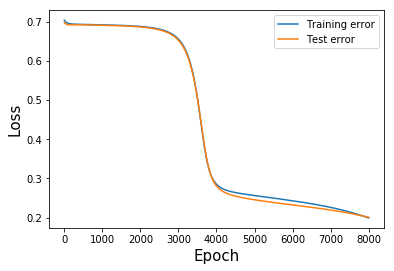

In [8]:
plt.plot(log_dic['epoch'], log_dic['loss'], label= 'Training error')
plt.plot(log_dic['epoch'], log_dic['loss_gen'], label= 'Test error')
plt.xlabel('Epoch', fontsize= 15)
plt.ylabel('Loss', fontsize= 15)
plt.legend()
plt.show()

In [12]:
save_obj(log_dic, 'tishby_epoch_8000_loss_019906')